In [43]:
# Import all necessary tools

import os
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from skimage.io import imread,imsave
from tqdm import tqdm
from pathlib import Path

import pickle
    
from optimal3dtracks.utils_3Dtracking import (
    calculate_Gaussian_parameters,calculate_track_sections,concatenate_track_sections,
    save_intensity_for_TrackMate,save_as_TrackMate,load_TrackMate,
    show_4d_with_contours, project_colours, generate_tree)


In [44]:
# Data directory and results directories

folder = './'
intensity_folder = 'intensity'
label_folder = 'label'
tracks_folder = 'tracks'
TrackMate_folder = 'TrackMate'
Gaussian_parameters_folder = 'tracks/Gaussian_parameters'
affine_folder = 'tracks/affines'
track_sections_folder = 'tracks/track_sections'

if not os.path.isdir(folder + tracks_folder):
    os.makedirs(folder + tracks_folder)
if not os.path.isdir(folder + Gaussian_parameters_folder):
    os.makedirs(folder + Gaussian_parameters_folder)
if not os.path.isdir(folder + affine_folder):
    os.makedirs(folder + affine_folder)
if not os.path.isdir(folder + track_sections_folder):
    os.makedirs(folder + track_sections_folder)
if not os.path.isdir(folder + TrackMate_folder):
    os.makedirs(folder + TrackMate_folder)


## Automated tracking using Optimal3dTracks

In [45]:
# Calculate and save Gaussian parameters for each region at each time point

label_files = sorted(glob(folder + label_folder + '/*.tif'))[:]
intensity_files = sorted(glob(folder + intensity_folder + '/*.tif'))[:]
save_folder = folder + Gaussian_parameters_folder

resolution = np.array([2.67,0.232,0.232]) # eg. in um

calculate_Gaussian_parameters(label_files, intensity_files, save_folder, resolution)
    

./label\label_1.tif
./label\label_2.tif
./label\label_3.tif
./label\label_4.tif
./label\label_5.tif


'Finished calculating Gaussian parameters'

In [46]:
# Create track segments between consecutive time points

# Load data files
label_files = sorted(glob(folder + label_folder + '/*.tif'))[:]
intensity_files = sorted(glob(folder + intensity_folder + '/*.tif'))[:]
Gaussian_parameter_files = sorted(glob(folder + Gaussian_parameters_folder + '/*'))[:]
save_folder_for_affine = folder + affine_folder
save_folder_for_tracks = folder + track_sections_folder

frames = [int(os.path.splitext(os.path.basename(file))[0][10:]) for file in intensity_files]

resolution = np.array([2.67,0.232,0.232]) # in um
max_number_of_cells_per_timepoint = 1000 # it's unlikely that any time point contains more than 1000 
# segmented cells (including dirt). Make this as large as you like, but make sure that 
# n_timepoints*max_number_of_cells_per_timepoint < 2**32 to avoid running into number representation issues

calculate_track_sections(label_files, intensity_files, Gaussian_parameter_files, frames, save_folder_for_affine,
                              save_folder_for_tracks, resolution, max_number_of_cells_per_timepoint)

## This might give a few "Sinkhorn did not converge" warnings, but it's fine as long as all the marginals are small enough 
# (< 0.01)


./label\label_1.tif


C:\Users\ak2557\AppData\Local\anaconda3\Lib\site-packages\ot\bregman.py:536: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Marginals of transition matrix (ideally both zero) = 5.23974816338576e-10 , 0.0017988837784955322
./label\label_2.tif


C:\Users\ak2557\AppData\Local\anaconda3\Lib\site-packages\ot\bregman.py:536: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Marginals of transition matrix (ideally both zero) = 3.327218994942207e-10 , 0.001240760724319926
./label\label_3.tif


C:\Users\ak2557\AppData\Local\anaconda3\Lib\site-packages\ot\bregman.py:536: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Marginals of transition matrix (ideally both zero) = 5.606468386959148e-10 , 0.0009602543583863777
./label\label_4.tif
Marginals of transition matrix (ideally both zero) = 6.143502880576208e-10 , 0.0005175742676328983


C:\Users\ak2557\AppData\Local\anaconda3\Lib\site-packages\ot\bregman.py:536: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


'Finished calculating track sections'

In [47]:
# Concatenate track segments

Gaussian_parameter_files = sorted(glob(folder + Gaussian_parameters_folder + '/*'))[:]
track_files = sorted(glob(folder + track_sections_folder + '/*'))[:]
save_folder = folder

max_number_of_cells_per_timepoint = 1000 # SAME AS ABOVE

track_df, split_df, merge_df = concatenate_track_sections(track_files,Gaussian_parameter_files,
                                                          save_folder,max_number_of_cells_per_timepoint)

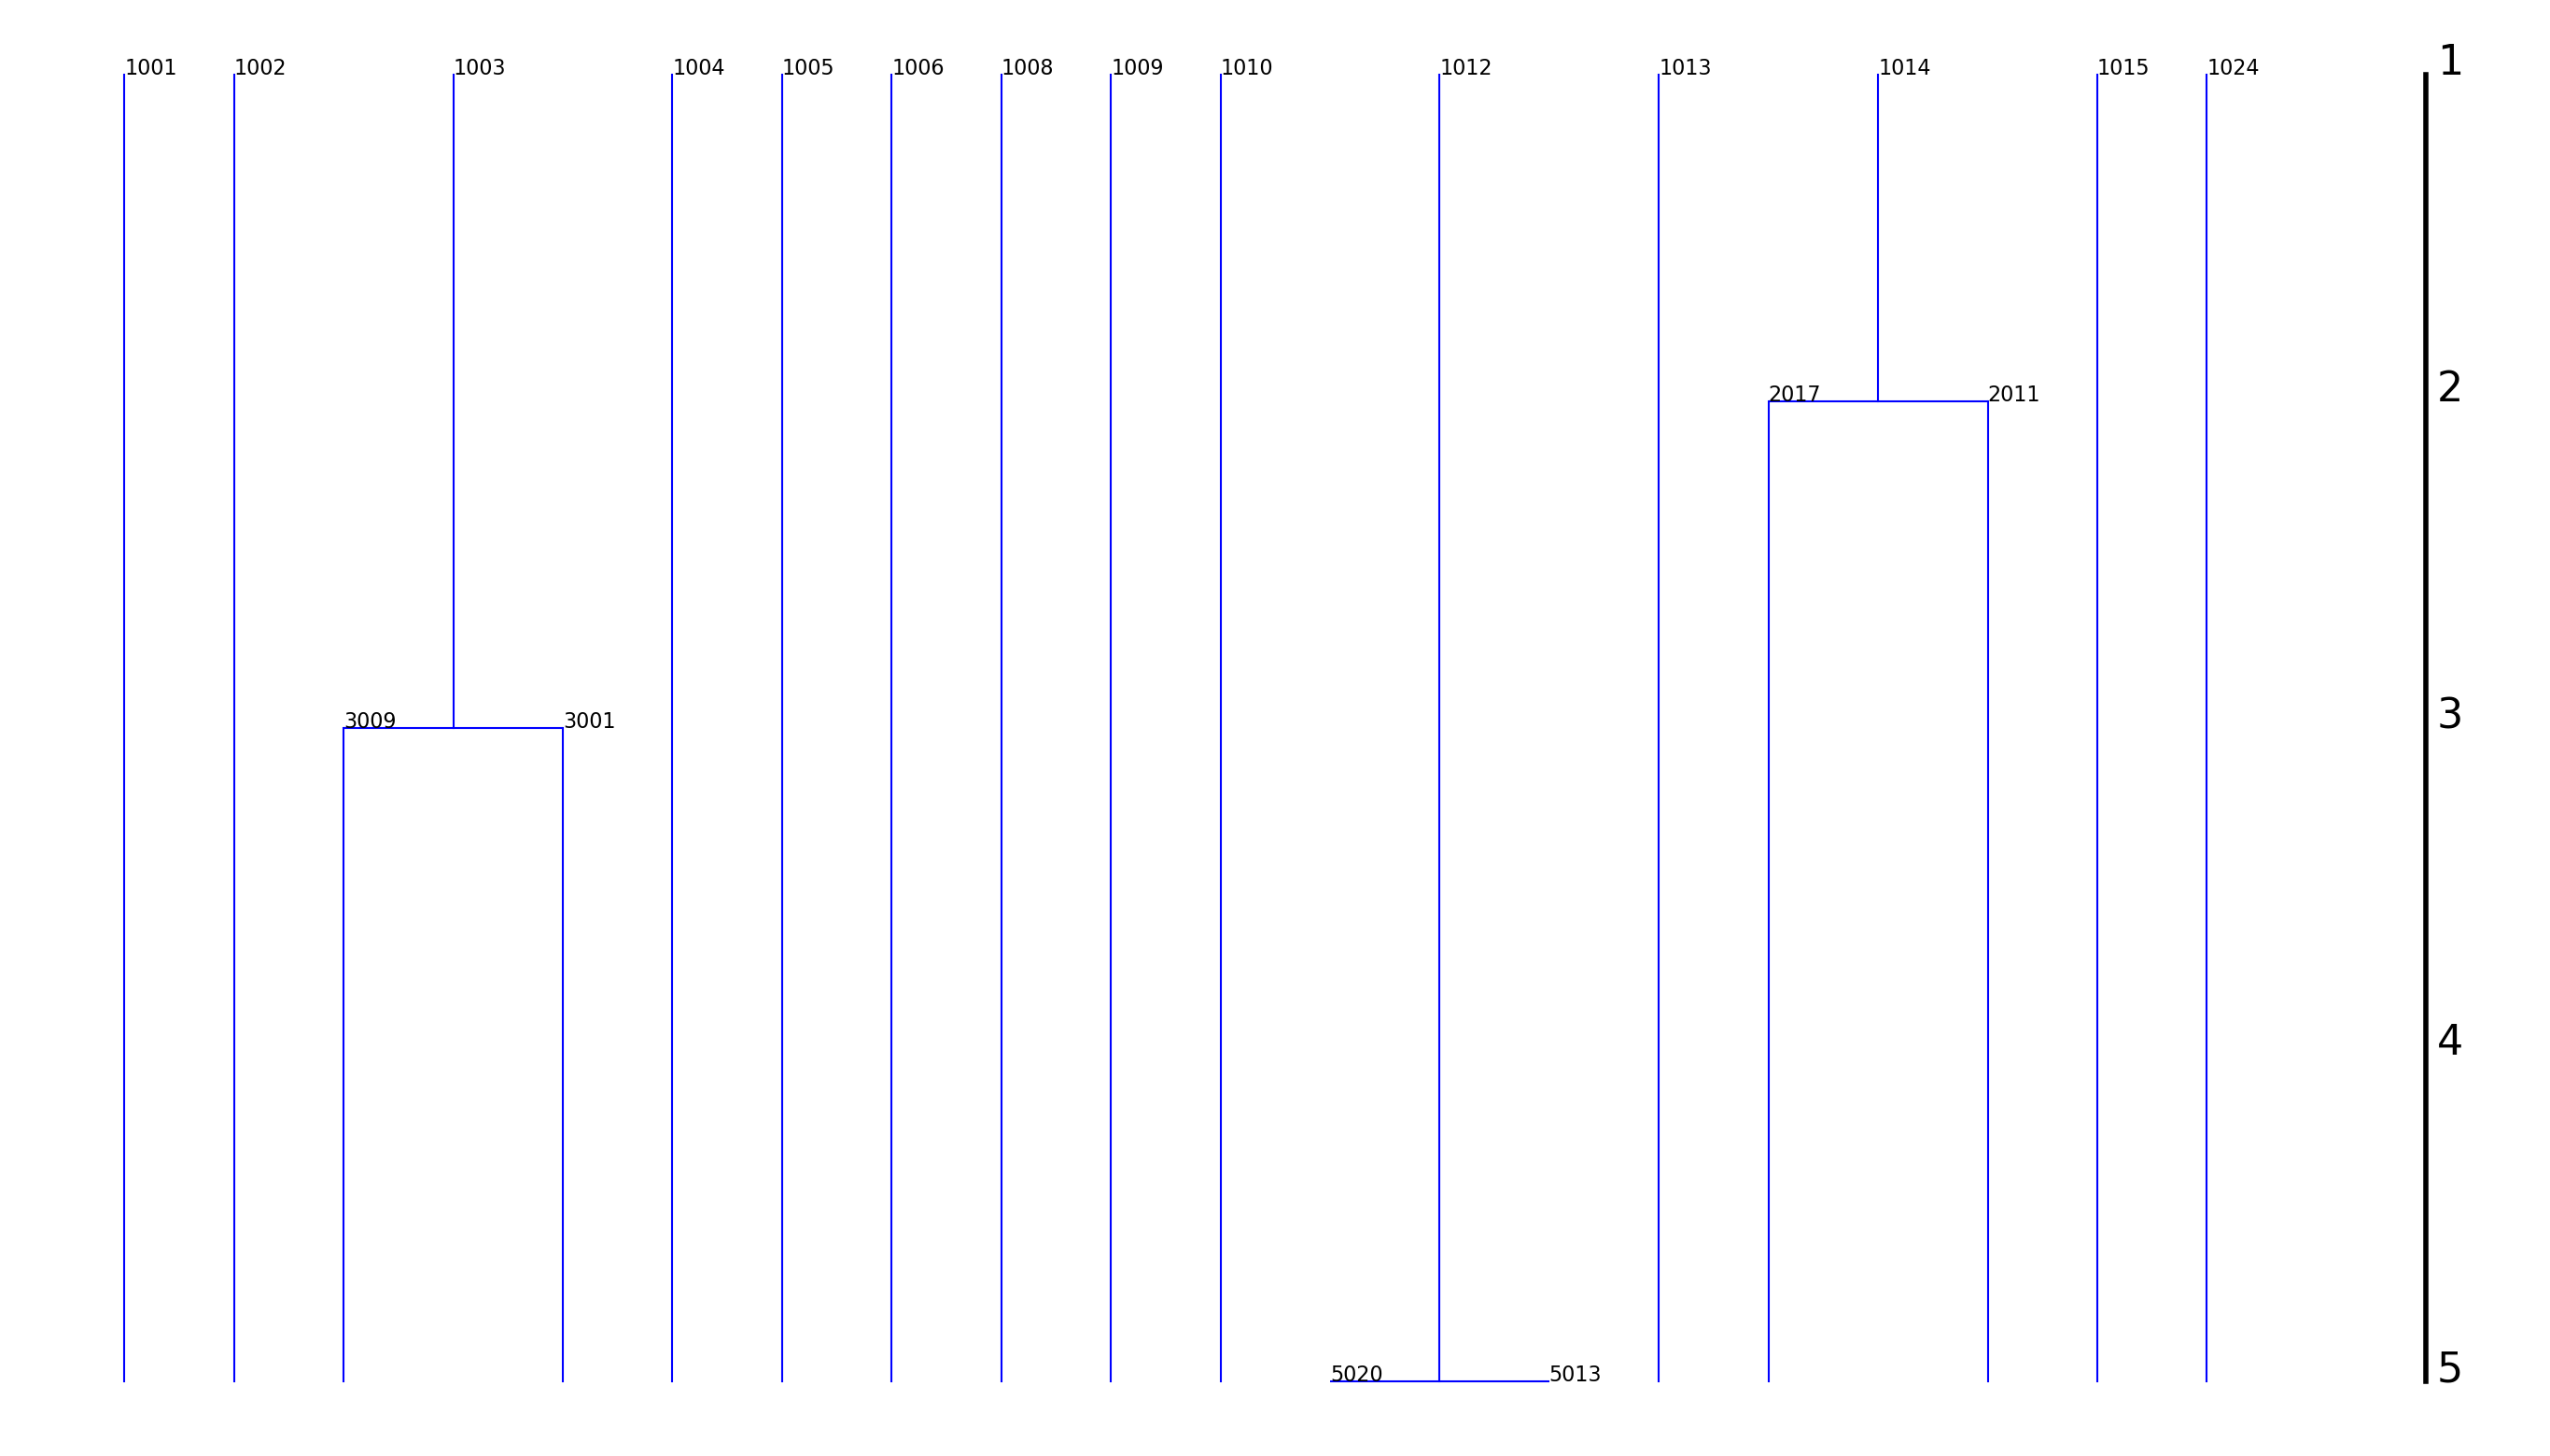

In [48]:
# Plot division tree
    
tree, start, end = generate_tree(track_df, split_df, merge_df)